# Reading Files

In [1]:
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from googletrans import Translator
import langdetect
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("listings.csv")
df_1 = df.drop(columns = ['name','host_about','neighbourhood','neighbourhood_group_cleansed','calendar_updated','bathrooms','license','last_scraped','listing_url','scrape_id','source','picture_url','host_url','host_name','host_thumbnail_url','host_picture_url','calendar_last_scraped','host_id'])


%store -r grouped_df
df_2 = grouped_df

In [3]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7566 entries, 0 to 7565
Data columns (total 57 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            7566 non-null   int64  
 1   description                                   7411 non-null   object 
 2   neighborhood_overview                         4194 non-null   object 
 3   host_since                                    7566 non-null   object 
 4   host_location                                 6232 non-null   object 
 5   host_response_time                            3932 non-null   object 
 6   host_response_rate                            3932 non-null   object 
 7   host_acceptance_rate                          4191 non-null   object 
 8   host_is_superhost                             7566 non-null   object 
 9   host_neighbourhood                            5234 non-null   o

# Removing Nans in the listings dataframe

In [4]:
nullseries = df_1.isnull().sum()
print(nullseries[nullseries > 0])

description                     155
neighborhood_overview          3372
host_location                  1334
host_response_time             3634
host_response_rate             3634
host_acceptance_rate           3375
host_neighbourhood             2332
bathrooms_text                    4
bedrooms                        205
beds                             94
first_review                   1357
last_review                    1357
review_scores_rating           1357
review_scores_accuracy         1481
review_scores_cleanliness      1480
review_scores_checkin          1485
review_scores_communication    1481
review_scores_location         1485
review_scores_value            1487
reviews_per_month              1357
dtype: int64


In [5]:
df_1.fillna({'reviews_per_month':0}, inplace=True)
df_1.fillna({'host_location':'No Location Given'}, inplace=True)
df_1.fillna({'host_neighbourhood':'No Neighbourhood Given'}, inplace=True)
df_1.fillna({'description':'No Description Provided'}, inplace = True)
df_1.fillna({'neighborhood_overview':'No Neighborhood Provided'}, inplace = True)
df_1.fillna({'host_response_time': 'Not mentioned'}, inplace=True)
df_1.fillna({'first_review': 0}, inplace=True)
df_1.fillna({'last_review': 0}, inplace=True)

## Removing Nan's in Rating Columns by imputing mean

In [6]:
df_1.fillna({'review_scores_rating': df_1['review_scores_rating'].mean()}, inplace=True)
df_1.fillna({'review_scores_accuracy': df_1['review_scores_accuracy'].mean()}, inplace=True)
df_1.fillna({'review_scores_cleanliness': df_1['review_scores_cleanliness'].mean()}, inplace=True)
df_1.fillna({'review_scores_checkin': df_1['review_scores_checkin'].mean()}, inplace=True)
df_1.fillna({'review_scores_communication': df_1['review_scores_communication'].mean()}, inplace=True)
df_1.fillna({'review_scores_location': df_1['review_scores_location'].mean()}, inplace=True)
df_1.fillna({'review_scores_value': df_1['review_scores_value'].mean()}, inplace=True)

## Removing Nan's in Bathrooms, Bedrooms and Beds

In [7]:
bathrooms = pd.DataFrame(data=df_1, columns=['bathrooms_text'])
result = bathrooms.bathrooms_text.str.extract('([^a-zA-Z]+)([a-zA-Z]+)', expand=True)
result.columns = ['Number', 'Text']
df_1['bathrooms'] = result['Number']
df_1 = df_1.drop(columns = ['bathrooms_text'])

df_1['bathrooms'] = df_1['bathrooms'].replace(['-',' '],[0.5,0.5])
df_1['bathrooms'] = pd.to_numeric(df_1['bathrooms'])

In [8]:
null_index = df_1[df_1['bathrooms'].isnull()].index
for index in null_index:
    property_type = df_1.loc[index, 'property_type']
    mean_bathrooms = round(df_1.bathrooms[df_1['property_type'] == property_type].mean())
    df_1.loc[index, 'bathrooms'] = mean_bathrooms

In [9]:
null_index = df_1[df_1['bedrooms'].isnull()].index
df_1['bedrooms'] = df_1['bedrooms'].fillna(0)
df_1['bedrooms'] = df_1['bedrooms'].astype(int)
for index in null_index:
    property_type = df_1.loc[index, 'property_type']
    mean_bedrooms = round(df_1.bedrooms[df_1['property_type'] == property_type].mean())
    df_1.loc[index, 'bedrooms'] = mean_bedrooms

In [10]:
null_index = df_1[df_1['beds'].isnull()].index
df_1['beds'] = df_1['beds'].fillna(0)
df_1['beds'] = df_1['beds'].astype(int)
for index in null_index:
    property_type = df_1.loc[index, 'property_type']
    mean_beds = round(df_1.beds[df_1['property_type'] == property_type].mean())
    df_1.loc[index, 'beds'] = mean_beds

## Removing Nan's in host response rate and acceptance rate

In [11]:
df_1['host_response_rate'] = df_1['host_response_rate'].str.rstrip('%').astype('float') / 100.0
df_1['host_acceptance_rate'] = df_1['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0
df_1.fillna({'host_response_rate': df_1['host_response_rate'].mean()}, inplace=True)
df_1.fillna({'host_acceptance_rate': df_1['host_acceptance_rate'].mean()}, inplace=True)

In [12]:
df_1['host_since'] = pd.to_datetime(df_1['host_since']).astype(int)
df_1['first_review'] = pd.to_datetime(df_1['first_review']).astype(int)
df_1['last_review'] = pd.to_datetime(df_1['last_review']).astype(int)

## Delete Rows when Host cancelled the reservation and no other booking there

In [13]:
indices = df_1[df_1['review_scores_rating'] == 0].index
df_1.drop(indices, inplace=True)

# Taking the Target variables into Y and dropping the columns

In [14]:
y_1 = df_1['review_scores_rating']
y_2 = df_1['review_scores_accuracy']
y_3 = df_1['review_scores_cleanliness']
y_4 = df_1['review_scores_checkin']
y_5 = df_1['review_scores_communication']
y_6 = df_1['review_scores_location']
y_7 = df_1['review_scores_value']


df_1 = df_1.drop(columns = ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value'])

# Cleaning and Encoding columns

In [15]:
#Clean Columns using Regular Expression
def clean_column(paragraph):
    paragraph = re.sub(r'<[^>]*>', ' ', paragraph)
    paragraph = re.sub(r'[^a-zA-Z ]', ' ', paragraph)
    paragraph = re.sub(r'[^\w\s]', ' ', paragraph)
    paragraph = paragraph.lower()
    return paragraph

In [16]:
pd.set_option('display.max_columns', None)
df_1.head()

,id,description,neighborhood_overview,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,bathrooms
0,44077,Our house was built in 1937 when there was ple...,I like our neighbourhood as there is no shorta...,1281052800000000000,"Dublin, Ireland",within an hour,1.00,0.99,t,Churchtown,2,2,"['email', 'phone']",t,t,Dn Laoghaire-Rathdown,53.29178,-6.25792,Private room in bungalow,Private room,2,1,2,"[""Oven"", ""Hot water kettle"", ""Fire extinguishe...",$70.00,3,1125,3,3,1125,1125,3.0,1125.0,t,2,11,18,104,258,31,7,1300579200000000000,1662681600000000000,f,2,0,2,0,1.85,1.5
1,85156,Our Cottage is a charming light filled cottage...,"I love Dundrum and its surrounding areas ,<br ...",1281052800000000000,"Dublin, Ireland",within an hour,1.00,0.99,t,Churchtown,2,2,"['email', 'phone']",t,t,Dn Laoghaire-Rathdown,53.29209,-6.25624,Private room in bungalow,Private room,2,1,1,"[""Oven"", ""Fire extinguisher"", ""Dryer"", ""Hanger...",$67.00,3,21,3,3,21,21,3.0,21.0,t,3,9,21,110,210,28,4,1306195200000000000,1662854400000000000,f,2,0,2,0,1.53,1.5
2,159889,Washing can be done at a cost of €5 per load....,Plenty of buses into the city and the area is ...,1309478400000000000,"Dublin, Ireland",within an hour,1.00,0.95,f,Beaumont,3,4,"['email', 'phone']",t,t,Dublin City,53.39027,-6.23547,Private room in home,Private room,1,1,1,"[""Oven"", ""Fire extinguisher"", ""Hangers"", ""Carb...",$45.00,2,21,1,2,21,21,2.0,21.0,t,1,16,36,290,355,44,6,1332201600000000000,1661990400000000000,f,3,0,3,0,2.78,2.0
3,162809,A nice place to relax after the bustle of the ...,"Close to the sea, hill walks and the city - vi...",1309737600000000000,"Dublin, Ireland",within an hour,0.92,0.87,t,Blackrock,2,2,"['email', 'phone']",t,t,Dn Laoghaire-Rathdown,53.28326,-6.19188,Private room in townhouse,Private room,6,2,4,"[""Oven"", ""Hot water kettle"", ""Fire extinguishe...",$80.00,1,12,1,1,12,12,1.0,12.0,t,2,2,2,74,326,41,1,1433116800000000000,1661904000000000000,f,2,0,2,0,3.68,1.5
4,165828,"Don't just visit Dublin, experience Dublin in ...","Enjoy a walk along the grand canal, or just ob...",1309996800000000000,Ireland,within an hour,1.00,0.91,f,Kilmainham,5,5,"['email', 'phone']",t,t,Dublin City,53.33744,-6.32363,Entire rental unit,Entire home/apt,5,1,3,"[""Fire extinguisher"", ""Dryer"", ""Hangers"", ""Ind...",$251.00,3,365,3,3,365,365,3.0,365.0,t,1,4,21,31,64,17,0,1319500800000000000,1656374400000000000,t,5,5,0,0,0.48,1.0


## Scaling and Encoding Columns

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
encoder_response_time = LabelEncoder()
encoder_super_host = LabelEncoder()
encoder_has_availability = LabelEncoder()
encoder_instant_bookable = LabelEncoder()
encoder_host_has_profile_pic = LabelEncoder()
encoder_host_identity_verified = LabelEncoder()

scaler_host_since = StandardScaler()
scaler_price = StandardScaler()
scaler_first_review = StandardScaler()
scaler_last_review = StandardScaler()
scaler_minimum_nights = StandardScaler()
scaler_maximum_nights = StandardScaler()
scaler_minimum_minimum_nights = StandardScaler()
scaler_maximum_minimum_nights = StandardScaler()
scaler_minimum_maximum_nights = StandardScaler()
scaler_maximum_maximum_nights = StandardScaler()
scaler_minimum_nights_avg_ntm = StandardScaler()
scaler_maximum_nights_avg_ntm = StandardScaler()
scaler_availability_30 = StandardScaler()
scaler_availability_60 = StandardScaler()
scaler_availability_90 = StandardScaler()
scaler_availability_365 = StandardScaler()
scaler_number_of_reviews = StandardScaler()
scaler_number_of_reviews_ltm = StandardScaler()
scaler_number_of_reviews_l30d = StandardScaler()

### Scaling

In [18]:
scaler_host_since.fit(df_1[['host_since']])
df_1['host_since'] = scaler_host_since.transform(df_1[['host_since']])


df_1['price'] = df_1['price'].apply(lambda x: re.sub(r'[$,]', '', x)).astype('float')
price = df_1['price'].values.reshape(-1, 1)
scaler_price.fit(price)
df_1['price'] = scaler_price.transform(price)

scaler_first_review.fit(df_1[['first_review']])
df_1['first_review'] = scaler_first_review.transform(df_1[['first_review']])

scaler_last_review.fit(df_1[['last_review']])
df_1['last_review'] = scaler_last_review.transform(df_1[['last_review']])

scaler_minimum_nights.fit(df_1[['minimum_nights']])
df_1['minimum_nights'] = scaler_minimum_nights.transform(df_1[['minimum_nights']])

scaler_maximum_nights.fit(df_1[['maximum_nights']])
df_1['maximum_nights'] = scaler_maximum_nights.transform(df_1[['maximum_nights']])

scaler_minimum_minimum_nights.fit(df_1[['minimum_minimum_nights']])
df_1['minimum_minimum_nights'] = scaler_minimum_minimum_nights.transform(df_1[['minimum_minimum_nights']])

scaler_maximum_minimum_nights.fit(df_1[['maximum_minimum_nights']])
df_1['maximum_minimum_nights'] = scaler_maximum_minimum_nights.transform(df_1[['maximum_minimum_nights']])

scaler_minimum_maximum_nights.fit(df_1[['minimum_maximum_nights']])
df_1['minimum_maximum_nights'] = scaler_minimum_maximum_nights.transform(df_1[['minimum_maximum_nights']])

scaler_maximum_maximum_nights.fit(df_1[['maximum_maximum_nights']])
df_1['maximum_maximum_nights'] = scaler_maximum_maximum_nights.transform(df_1[['maximum_maximum_nights']])

scaler_minimum_nights_avg_ntm.fit(df_1[['minimum_nights_avg_ntm']])
df_1['minimum_nights_avg_ntm'] = scaler_minimum_nights_avg_ntm.transform(df_1[['minimum_nights_avg_ntm']])

scaler_maximum_nights_avg_ntm.fit(df_1[['maximum_nights_avg_ntm']])
df_1['maximum_nights_avg_ntm'] = scaler_maximum_nights_avg_ntm.transform(df_1[['maximum_nights_avg_ntm']])

scaler_availability_30.fit(df_1[['availability_30']])
df_1['availability_30'] = scaler_availability_30.transform(df_1[['availability_30']])

scaler_availability_60.fit(df_1[['availability_60']])
df_1['availability_60'] = scaler_availability_60.transform(df_1[['availability_60']])

scaler_availability_90.fit(df_1[['availability_90']])
df_1['availability_90'] = scaler_availability_90.transform(df_1[['availability_90']])

scaler_availability_365.fit(df_1[['availability_365']])
df_1['availability_365'] = scaler_availability_365.transform(df_1[['availability_365']])

scaler_number_of_reviews.fit(df_1[['number_of_reviews']])
df_1['number_of_reviews'] = scaler_number_of_reviews.transform(df_1[['number_of_reviews']])

scaler_number_of_reviews_ltm.fit(df_1[['number_of_reviews_ltm']])
df_1['number_of_reviews_ltm'] = scaler_number_of_reviews_ltm.transform(df_1[['number_of_reviews_ltm']])

scaler_number_of_reviews_l30d.fit(df_1[['number_of_reviews_l30d']])
df_1['number_of_reviews_l30d'] = scaler_number_of_reviews_l30d.transform(df_1[['number_of_reviews_l30d']])

### Label Encoding

In [19]:

encoder_has_availability.fit(df_1['has_availability'])
df_1['has_availability'] = encoder_has_availability.transform(df_1['has_availability'])

encoder_instant_bookable.fit(df_1['instant_bookable'])
df_1['instant_bookable'] = encoder_instant_bookable.transform(df_1['instant_bookable'])

encoder_host_has_profile_pic.fit(df_1['host_has_profile_pic'])
df_1['host_has_profile_pic'] = encoder_host_has_profile_pic.transform(df_1['host_has_profile_pic'])

encoder_host_identity_verified.fit(df_1['host_identity_verified'])
df_1['host_identity_verified'] = encoder_host_identity_verified.transform(df_1['host_identity_verified'])

encoder_super_host.fit(df_1['host_is_superhost'])
df_1['host_is_superhost'] = encoder_super_host.transform(df_1['host_is_superhost'])

encoder_response_time.fit(df_1['host_response_time'])
df_1['host_response_time'] = encoder_response_time.transform(df_1['host_response_time'])

### One Hot Encoding

In [20]:
one_hot = pd.get_dummies(df_1['room_type'],prefix='room_type')
df_1 = pd.concat([df_1, one_hot], axis=1)
df_1.drop(columns=['room_type'], axis=1, inplace=True)

one_hot = pd.get_dummies(df_1['property_type'],prefix='room_type')
df_1 = pd.concat([df_1, one_hot], axis=1)
df_1.drop(columns=['property_type'], axis=1, inplace=True)

one_hot = pd.get_dummies(df_1['host_location'],prefix='host_location')
df_1 = pd.concat([df_1, one_hot], axis=1)
df_1.drop(columns=['host_location'], axis=1, inplace=True)

one_hot = pd.get_dummies(df_1['host_neighbourhood'],prefix='host_neighbourhood')
df_1 = pd.concat([df_1, one_hot], axis=1)
df_1.drop(columns=['host_neighbourhood'], axis=1, inplace=True)

one_hot = pd.get_dummies(df_1['neighbourhood_cleansed'],prefix='neighbourhood_cleansed')
df_1 = pd.concat([df_1, one_hot], axis=1)
df_1.drop(columns=['neighbourhood_cleansed'], axis=1, inplace=True)

### Amenities and Host Verification Encoding

In [21]:
# make a dictionary from the amenities
amenities_counter = Counter()

# delete {},"",/,\, and split them by comma
df_1['amenities'].astype('str').str.strip('{}')\
                                       .str.replace('"', '')\
.str.lstrip('["')\
.str.rstrip(']"')\
                                       .str.lstrip('\"')\
                                       .str.rstrip('\"')\
                                       .str.split(',')\
                                       .apply(amenities_counter.update)

# check how many amenities we have in total
print(len(amenities_counter))
amenities_list = [(amenity, count) for amenity, count in amenities_counter.items() if count >= 100]
print(len(amenities_list))

1141
118


In [22]:
for item,_ in amenities_counter.most_common():
    col_name = 'amenity_' + item.replace(" ", "_")
    df_1[col_name] = df_1['amenities'].astype('str').apply(lambda x: int(item in x))
    

df_1.drop(columns=['amenities'], axis=1, inplace=True)

/var/folders/sd/mk1brx6n5gz27fv76t_n0x800000gn/T/ipykernel_94463/167276443.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1[col_name] = df_1['amenities'].astype('str').apply(lambda x: int(item in x))
/var/folders/sd/mk1brx6n5gz27fv76t_n0x800000gn/T/ipykernel_94463/167276443.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1[col_name] = df_1['amenities'].astype('str').apply(lambda x: int(item in x))
/var/folders/sd/mk1brx6n5gz27fv76t_n0x800000gn/T/ipykernel_94463/167276443.py:3: PerformanceWarning: DataFrame is high

/var/folders/sd/mk1brx6n5gz27fv76t_n0x800000gn/T/ipykernel_94463/167276443.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1[col_name] = df_1['amenities'].astype('str').apply(lambda x: int(item in x))
/var/folders/sd/mk1brx6n5gz27fv76t_n0x800000gn/T/ipykernel_94463/167276443.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1[col_name] = df_1['amenities'].astype('str').apply(lambda x: int(item in x))
/var/folders/sd/mk1brx6n5gz27fv76t_n0x800000gn/T/ipykernel_94463/167276443.py:3: PerformanceWarning: DataFrame is high

/var/folders/sd/mk1brx6n5gz27fv76t_n0x800000gn/T/ipykernel_94463/167276443.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1[col_name] = df_1['amenities'].astype('str').apply(lambda x: int(item in x))
/var/folders/sd/mk1brx6n5gz27fv76t_n0x800000gn/T/ipykernel_94463/167276443.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1[col_name] = df_1['amenities'].astype('str').apply(lambda x: int(item in x))
/var/folders/sd/mk1brx6n5gz27fv76t_n0x800000gn/T/ipykernel_94463/167276443.py:3: PerformanceWarning: DataFrame is high

/var/folders/sd/mk1brx6n5gz27fv76t_n0x800000gn/T/ipykernel_94463/167276443.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1[col_name] = df_1['amenities'].astype('str').apply(lambda x: int(item in x))
/var/folders/sd/mk1brx6n5gz27fv76t_n0x800000gn/T/ipykernel_94463/167276443.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1[col_name] = df_1['amenities'].astype('str').apply(lambda x: int(item in x))
/var/folders/sd/mk1brx6n5gz27fv76t_n0x800000gn/T/ipykernel_94463/167276443.py:3: PerformanceWarning: DataFrame is high

/var/folders/sd/mk1brx6n5gz27fv76t_n0x800000gn/T/ipykernel_94463/167276443.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1[col_name] = df_1['amenities'].astype('str').apply(lambda x: int(item in x))
/var/folders/sd/mk1brx6n5gz27fv76t_n0x800000gn/T/ipykernel_94463/167276443.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1[col_name] = df_1['amenities'].astype('str').apply(lambda x: int(item in x))
/var/folders/sd/mk1brx6n5gz27fv76t_n0x800000gn/T/ipykernel_94463/167276443.py:3: PerformanceWarning: DataFrame is high

/var/folders/sd/mk1brx6n5gz27fv76t_n0x800000gn/T/ipykernel_94463/167276443.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1[col_name] = df_1['amenities'].astype('str').apply(lambda x: int(item in x))
/var/folders/sd/mk1brx6n5gz27fv76t_n0x800000gn/T/ipykernel_94463/167276443.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1[col_name] = df_1['amenities'].astype('str').apply(lambda x: int(item in x))
/var/folders/sd/mk1brx6n5gz27fv76t_n0x800000gn/T/ipykernel_94463/167276443.py:3: PerformanceWarning: DataFrame is high

In [23]:
# make a dictionary from the verification
verification_counter = Counter()
pattern = r'[^a-zA-Z ]'
df_1['host_verifications'] = df_1['host_verifications'].apply(lambda x: re.sub(pattern, '', x))
# delete {},"",/,\, and split them by comma
df_1['host_verifications'].astype('str').str.split(' ').apply(verification_counter.update)

verification_counter.update({'NotSpecified': verification_counter.pop('')})
# check how many amenities we have in total
print(len(verification_counter))

4


In [24]:
for item,_ in verification_counter.most_common():
    col_name = 'verification_' + item.replace(" ", "_")
    df_1[col_name] = df_1['host_verifications'].astype('str').apply(lambda x: int(item in x))
    
    
df_1.drop(columns=['host_verifications'], axis=1, inplace=True)

/var/folders/sd/mk1brx6n5gz27fv76t_n0x800000gn/T/ipykernel_94463/2080663814.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1[col_name] = df_1['host_verifications'].astype('str').apply(lambda x: int(item in x))
/var/folders/sd/mk1brx6n5gz27fv76t_n0x800000gn/T/ipykernel_94463/2080663814.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1[col_name] = df_1['host_verifications'].astype('str').apply(lambda x: int(item in x))
/var/folders/sd/mk1brx6n5gz27fv76t_n0x800000gn/T/ipykernel_94463/2080663814.py:3: PerformanceWarni

## Translating non english rows Description and Neighborhood Overview columns

In [25]:
def is_english(text):
    try:
        return langdetect.detect(text) == 'en'
    except:
        return False
    
non_english_rows = df_1['description'].where(df_1['description'].apply(is_english)).index[df_1['description'].apply(is_english) == False]
non_english_rows_nei = df_1['neighborhood_overview'].where(df_1['neighborhood_overview'].apply(is_english)).index[df_1['neighborhood_overview'].apply(is_english) == False]

In [26]:
translator = Translator()
for index in non_english_rows:
    df_1.loc[index, 'description'] = translator.translate(df_1.loc[index, 'description'], dest='en').text
for index in non_english_rows_nei:
    df_1.loc[index, 'neighborhood_overview'] = translator.translate(df_1.loc[index, 'neighborhood_overview'], dest='en').text    

# Lemmatization and Stop Word Removal for Description and Neighborhood Overview

In [27]:
#Lemmetization, Stop Word Removal for Description.

for row in range(df_1.shape[0]):
    paragraph = df_1.iloc[row,1]
    try:
        if(type(paragraph)==str):
            sentences = nltk.sent_tokenize(paragraph)
            lemmatizer = WordNetLemmatizer()
            for i in range(len(sentences)):
                review = clean_column(sentences[i])
                review = review.split()
                words = [lemmatizer.lemmatize(word) for word in review if word.lower() not in set(stopwords.words('english'))]
                sentences[i] = ' '.join(words)
            paragraph = ' '.join(sentences)
            df_1.iloc[row,1] = paragraph
    except:
        print(e)

In [28]:
#Lemmetization, Stop Word Removal for Neighborhood_overview.

for row in range(df_1.shape[0]):
    paragraph = df_1.iloc[row,2]
    try:
        if(type(paragraph)==str):
            sentences = nltk.sent_tokenize(paragraph)
            lemmatizer = WordNetLemmatizer()
            for i in range(len(sentences)):
                review = clean_column(sentences[i])
                review = review.split()
                words = [lemmatizer.lemmatize(word) for word in review if word.lower() not in set(stopwords.words('english'))]
                sentences[i] = ' '.join(words)
            paragraph = ' '.join(sentences)
            df_1.iloc[row,2] = paragraph
    except:
        print(e)

In [29]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7446 entries, 0 to 7565
Columns: 2052 entries, id to verification_NotSpecified
dtypes: float64(25), int64(1161), object(2), uint8(864)
memory usage: 73.9+ MB


# Merging both the Reviews and Listings Data frames

In [30]:
final_df = pd.merge(df_1,df_2,how = 'left', left_on = 'id', right_on = 'listing_id')
final_df = final_df.drop(columns = ['id','listing_id'])
final_df.fillna({'translated':'No Review Given'}, inplace=True)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7446 entries, 0 to 7445
Columns: 2052 entries, description to translated
dtypes: float64(25), int64(1160), object(3), uint8(864)
memory usage: 73.7+ MB


# Testing Various Values of Max Features in TF IDF

In [34]:
# load the data and split into features and labels
X= final_df
y = y_1
mean = []
std = []
score = []
def get_score(max_features,X,y):
    # create a TfidfVectorizer with the specified maximum number of features
    vectorizer1 = TfidfVectorizer(max_features=max_features, ngram_range=(1,3))    
    tfidf_1 = vectorizer1.fit_transform(X['description'])
    df_tfidf = pd.DataFrame(tfidf_1.toarray(), columns=['description_' + x for x in vectorizer1.get_feature_names()])
    X = pd.concat([X, df_tfidf], axis=1)
    X.drop(columns=['description'], axis=1, inplace=True)
    
    vectorizer2 = TfidfVectorizer(max_features=max_features, ngram_range=(1,3)) 
    tfidf_2 = vectorizer2.fit_transform(X['neighborhood_overview'])
    df_tfidf = pd.DataFrame(tfidf_2.toarray(), columns=['neihborhood_overview_' + x for x in vectorizer2.get_feature_names()])
    X = pd.concat([X, df_tfidf], axis=1)
    X.drop(columns=['neighborhood_overview'], axis=1, inplace=True)
    
    vectorizer3 = TfidfVectorizer(max_features=max_features, ngram_range=(1,3)) 
    tfidf_3 = vectorizer3.fit_transform(X['translated'])
    df_tfidf = pd.DataFrame(tfidf_3.toarray(), columns=['translated_' + x for x in vectorizer3.get_feature_names()])
    X = pd.concat([X, df_tfidf], axis=1)
    X.drop(columns=['translated'], axis=1, inplace=True)
    
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = Ridge(alpha = 1)
    model.fit(X_train,Y_train)
    Y_pred = model.predict(X_test)
    
    
    # compute the cross-validation score
    score = mean_squared_error(Y_pred,Y_test)
    return score

# iterate over the different values of max_features and n_estimators
for max_features in [1000,5000,10000,20000,40000]:
    score.append(get_score(max_features,X,y))


/Users/haneeshsolasa/miniforge3/envs/env_final/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/haneeshsolasa/miniforge3/envs/env_final/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/haneeshsolasa/miniforge3/envs/env_final/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/haneeshsolasa/miniforge3/envs/env_fi

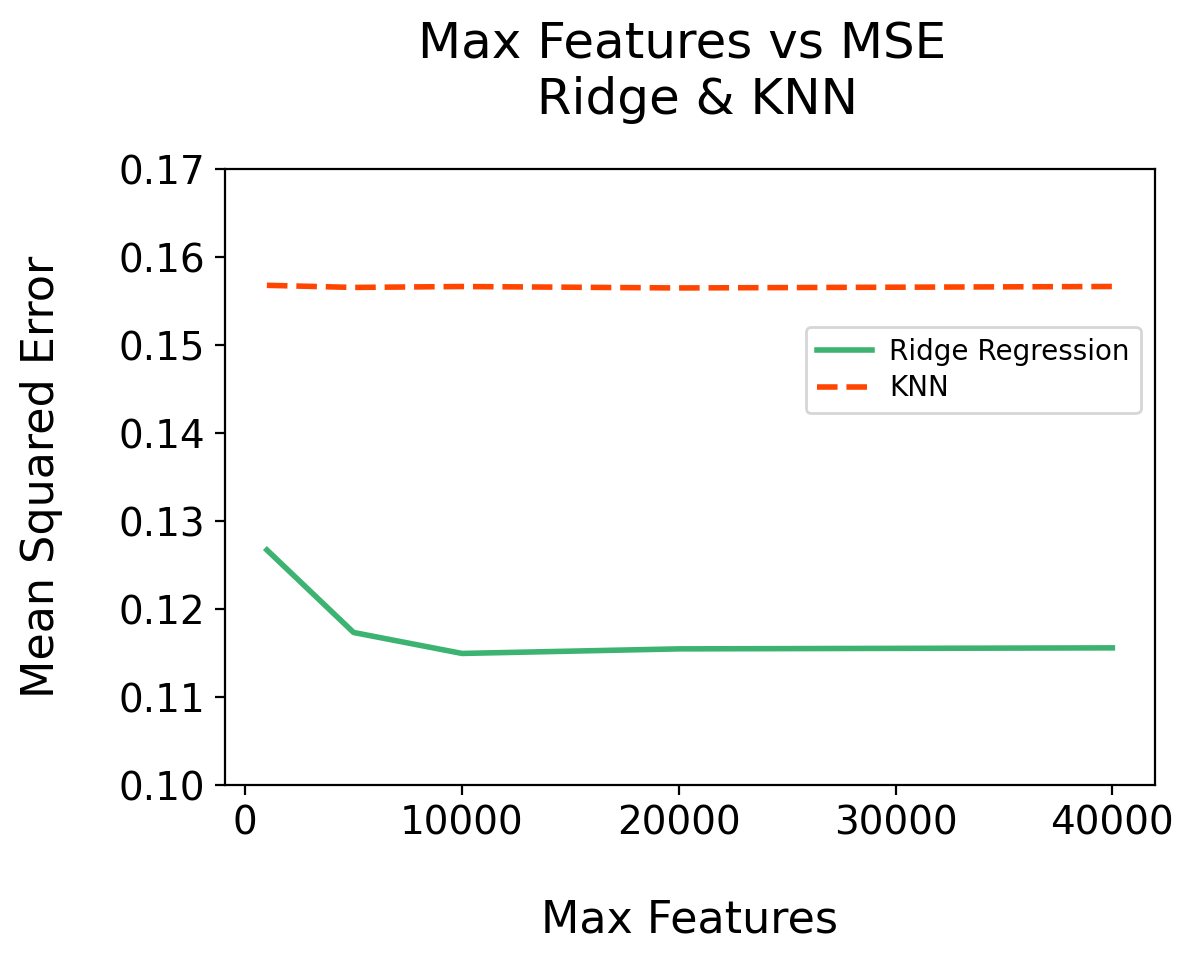

In [45]:
plt.figure(figsize=(6,4), dpi=200)
max_features = [1000,5000,10000,20000,40000]
import matplotlib.pyplot as plt

# Plot the values
plt.plot(max_features, score,label='Ridge Regression', color='mediumseagreen', linestyle='-', lw=2)
plt.plot(max_features,score_KNN,label='KNN', color='orangered', linestyle='--', lw=2)

# Add axis labels and a title
plt.xlabel('Max Features', fontsize=16, labelpad=20)
plt.ylabel('Mean Squared Error', fontsize=16, labelpad=20)
plt.ylim([0.1,0.17])
plt.title('Max Features vs MSE \n Ridge & KNN', fontsize=18, pad=20)
plt.tick_params(labelsize=14)

# Show the plot
plt.figlegend(loc='upper right', ncol=1, labelspacing=0.3,
              title_fontsize=12, fontsize=10, bbox_to_anchor=(0.9, 0.7),
              handletextpad=0.6, frameon=True)
plt.show()

In [39]:
# load the data and split into features and labels
X= final_df
y = y_1
mean = []
std = []
score_KNN = []
def get_score(max_features,X,y):
    # create a TfidfVectorizer with the specified maximum number of features
    vectorizer1 = TfidfVectorizer(max_features=max_features, ngram_range=(1,3))    
    tfidf_1 = vectorizer1.fit_transform(X['description'])
    df_tfidf = pd.DataFrame(tfidf_1.toarray(), columns=['description_' + x for x in vectorizer1.get_feature_names()])
    X = pd.concat([X, df_tfidf], axis=1)
    X.drop(columns=['description'], axis=1, inplace=True)
    
    vectorizer2 = TfidfVectorizer(max_features=max_features, ngram_range=(1,3)) 
    tfidf_2 = vectorizer2.fit_transform(X['neighborhood_overview'])
    df_tfidf = pd.DataFrame(tfidf_2.toarray(), columns=['neihborhood_overview_' + x for x in vectorizer2.get_feature_names()])
    X = pd.concat([X, df_tfidf], axis=1)
    X.drop(columns=['neighborhood_overview'], axis=1, inplace=True)
    
    vectorizer3 = TfidfVectorizer(max_features=max_features, ngram_range=(1,3)) 
    tfidf_3 = vectorizer3.fit_transform(X['translated'])
    df_tfidf = pd.DataFrame(tfidf_3.toarray(), columns=['translated_' + x for x in vectorizer3.get_feature_names()])
    X = pd.concat([X, df_tfidf], axis=1)
    X.drop(columns=['translated'], axis=1, inplace=True)
    
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = KNeighborsRegressor(n_neighbors = 20)
    model.fit(X_train,Y_train)
    Y_pred = model.predict(X_test)
    
    
    # compute the cross-validation score
    score = mean_squared_error(Y_pred,Y_test)
    return score

# iterate over the different values of max_features and n_estimators
for max_features in [1500,5000,10000,20000,40000]:
    score_KNN.append(get_score(max_features,X,y))


/Users/haneeshsolasa/miniforge3/envs/env_final/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/haneeshsolasa/miniforge3/envs/env_final/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/haneeshsolasa/miniforge3/envs/env_final/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/haneeshsolasa/miniforge3/envs/env_fi

In [40]:
score_KNN

[0.15678176537218358,
 0.15654141535351113,
 0.15664660183042808,
 0.15648404069862776,
 0.15664967234126387]

In [36]:
%store final_df
%store y_1
%store y_2
%store y_3
%store y_4
%store y_5
%store y_6
%store y_7

Stored 'final_df' (DataFrame)
Stored 'y_1' (Series)
Stored 'y_2' (Series)
Stored 'y_3' (Series)
Stored 'y_4' (Series)
Stored 'y_5' (Series)
Stored 'y_6' (Series)
Stored 'y_7' (Series)
